In [59]:
import math
import yfinance as yf
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler 
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

stock_data = yf.download('AAPL', start='2016-01-01', end='2022-05-01')
stock_data.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2015-12-31,26.752501,26.757500,26.205000,26.315001,24.130863,163649200
2016-01-04,25.652500,26.342501,25.500000,26.337500,24.151493,270597600
2016-01-05,26.437500,26.462500,25.602501,25.677500,23.546272,223164000
2016-01-06,25.139999,25.592501,24.967501,25.174999,23.085484,273829600
2016-01-07,24.670000,25.032499,24.107500,24.112499,22.111170,324377600


Text(0, 0.5, 'Prices ($)')

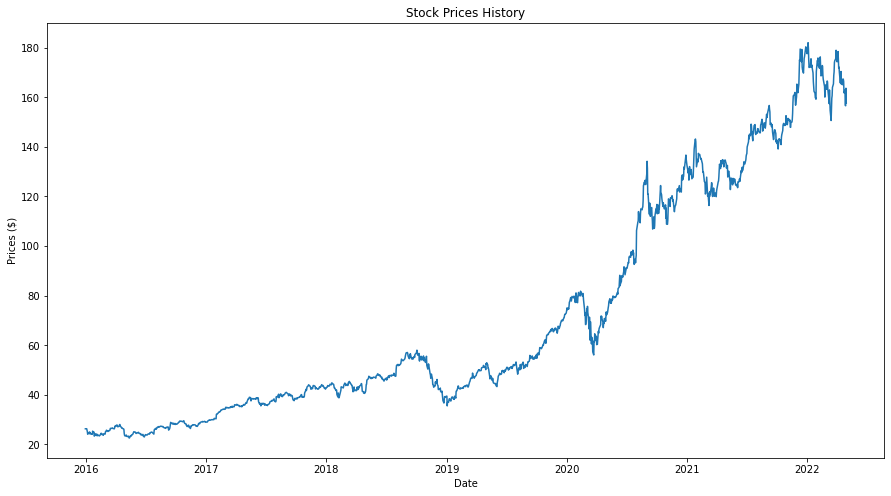

In [60]:
plt.figure(figsize=(15, 8))
plt.title('Stock Prices History')
plt.plot(stock_data['Close'])
plt.xlabel('Date')
plt.ylabel('Prices ($)')

In [61]:
close_prices = stock_data['Close']
values = close_prices.values
print(len(values))
training_data_len = math.ceil(len(values)* 0.8)

scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(values.reshape(-1,1))
train_data = scaled_data[0: training_data_len, :]
print(len(train_data))

x_train = []
y_train = []

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])
    
x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

1594
1276


In [62]:
test_data = scaled_data[training_data_len-60: , : ]
x_test = []
y_test = values[training_data_len:]

for i in range(60, len(test_data)):
  x_test.append(test_data[i-60:i, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [68]:
model = keras.Sequential()
model.add(layers.LSTM(128, return_sequences=True, name="Layer_1", input_shape=(x_train.shape[1], 1)))
model.add(layers.LSTM(128, return_sequences=True, name="Layer_2", input_shape=(x_train.shape[1], 1)))
model.add(layers.LSTM(128, return_sequences=False, name="Layer_3"))
model.add(layers.Dense(25, name="DLayer_1"))
model.add(layers.Dense(1, name="DLayer_2"))
model.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Layer_1 (LSTM)              (None, 60, 128)           66560     
                                                                 
 Layer_2 (LSTM)              (None, 60, 128)           131584    
                                                                 
 Layer_3 (LSTM)              (None, 128)               131584    
                                                                 
 DLayer_1 (Dense)            (None, 25)                3225      
                                                                 
 DLayer_2 (Dense)            (None, 1)                 26        
                                                                 
Total params: 332,979
Trainable params: 332,979
Non-trainable params: 0
_________________________________________________________________


In [69]:
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x_train, y_train, batch_size= 1, epochs=8)

Epoch 1/8
1216/1216 [==============================] - 19s 13ms/step - loss: 0.0031
Epoch 2/8
1216/1216 [==============================] - 16s 13ms/step - loss: 7.2799e-04
Epoch 3/8
1216/1216 [==============================] - 16s 13ms/step - loss: 8.7185e-04
Epoch 4/8
1216/1216 [==============================] - 17s 14ms/step - loss: 4.3355e-04
Epoch 5/8
1216/1216 [==============================] - 17s 14ms/step - loss: 4.2906e-04
Epoch 6/8
1216/1216 [==============================] - 16s 13ms/step - loss: 3.7517e-04
Epoch 7/8
1216/1216 [==============================] - 16s 13ms/step - loss: 7.7526e-04
Epoch 8/8
1216/1216 [==============================] - 17s 14ms/step - loss: 1.8582e-04


In [71]:
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)
rmse = np.sqrt(np.mean(predictions - y_test)**2)
rmse

10/10 [==============================] - 0s 17ms/step


2.2059495074194184

C:\Users\2020PITAIDS156\AppData\Local\Temp\ipykernel_2448\154904543.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validation['Predictions'] = predictions


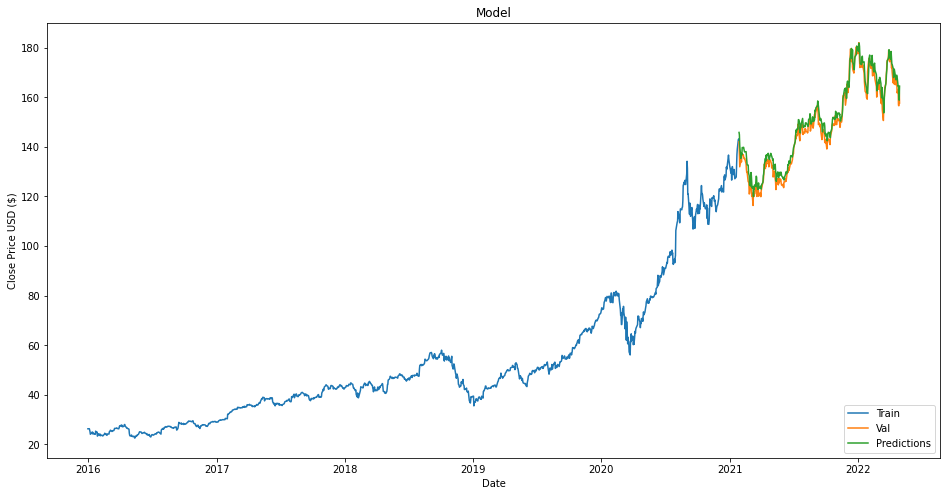

In [72]:
data = stock_data.filter(['Close'])
train = data[:training_data_len]
validation = data[training_data_len:]
validation['Predictions'] = predictions
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date')
plt.ylabel('Close Price USD ($)')
plt.plot(train)
plt.plot(validation[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()